# Лабораторна робота №1:Базові алгоритми класифікації з використанням бібліотеки Scikit-learn. Маринін Іван Павло Ігорович, ФІ-32мн

Датасет: https://www.kaggle.com/datasets/gabrielsantello/medical-malpractice-insurance-dataset

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier

1) завантаження даних, виведення назв колонок і розміру датасета:

In [2]:
df = pd.read_csv('medicalmalpractice.csv', delimiter=',')
file_size_mb = os.path.getsize("medicalmalpractice.csv") / (1024**2)
print(f"Розмір файлу: {file_size_mb:.2f} МБ\n")

df.info()
df.describe()

Розмір файлу: 3.62 МБ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79210 entries, 0 to 79209
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Amount            79210 non-null  int64 
 1   Severity          79210 non-null  int64 
 2   Age               79210 non-null  int64 
 3   Private Attorney  79210 non-null  int64 
 4   Marital Status    79210 non-null  int64 
 5   Specialty         79210 non-null  object
 6   Insurance         79210 non-null  object
 7   Gender            79210 non-null  object
dtypes: int64(5), object(3)
memory usage: 4.8+ MB


,Amount,Severity,Age,Private Attorney,Marital Status
count,79210.000000,79210.000000,79210.000000,79210.000000,79210.000000
mean,157484.554816,4.799659,42.701868,0.660889,1.889559
std,193135.093293,2.083439,19.811063,0.473411,1.002502
min,1576.000000,1.000000,0.000000,0.000000,0.000000
25%,43670.250000,3.000000,28.000000,0.000000,1.000000
50%,98131.000000,4.000000,43.000000,1.000000,2.000000
75%,154675.250000,7.000000,58.000000,1.000000,2.000000
max,926411.000000,9.000000,87.000000,1.000000,4.000000


2) опрацювання пропусків:

In [3]:
missing_values_per_column = df.isnull().sum()
print("Кількість пропусків у кожному стовпці:\n")
print(missing_values_per_column)

unknown_counts = df.apply(lambda x: x.value_counts().get('Unknown', 0))
print("\nКількість входжень 'Unknown' у кожному стовпці:")
print(unknown_counts)

df = df[df.apply(lambda x: x.ne('Unknown').all(), axis=1)]
print(df.info())

Кількість пропусків у кожному стовпці:

Amount              0
Severity            0
Age                 0
Private Attorney    0
Marital Status      0
Specialty           0
Insurance           0
Gender              0
dtype: int64

Кількість входжень 'Unknown' у кожному стовпці:
Amount                  0
Severity                0
Age                     0
Private Attorney        0
Marital Status          0
Specialty               0
Insurance           24052
Gender                  0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 55158 entries, 0 to 79209
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Amount            55158 non-null  int64 
 1   Severity          55158 non-null  int64 
 2   Age               55158 non-null  int64 
 3   Private Attorney  55158 non-null  int64 
 4   Marital Status    55158 non-null  int64 
 5   Specialty         55158 non-null  object
 6   Insurance         55

3) Візуалізувати дані: побудувати графік (heatmap), що відображає кореляції
ознак між собою і з цільовою змінною (розміткою); побудувати гістограми
розподілу ознак і boxplot-и ознак відносно цільової змінної (якщо ознак занадто багато
обмежитися декількома):

у даному датасеті є 3 колонки нечислового типу даних, а саме: Specialty, Insurance та Gender. Тоді конвертуємо ці дані у числові. Виникає проблема зі Specialty - виходить 19 нових колонок, що затрудняє візуалізацію даних у поєднанні з іншими ознаками. Тому вирішено прибрати цю ознаку із Датафрейму і зберегти її окремо (розподіл унікальних значень всередині неї наведено нижче).

In [4]:
Specialty = df['Specialty']
df.drop('Specialty', axis='columns', inplace=True)

df = pd.get_dummies(df, drop_first=True)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55158 entries, 0 to 79209
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Amount                          55158 non-null  int64
 1   Severity                        55158 non-null  int64
 2   Age                             55158 non-null  int64
 3   Private Attorney                55158 non-null  int64
 4   Marital Status                  55158 non-null  int64
 5   Insurance_No Insurance          55158 non-null  uint8
 6   Insurance_Private               55158 non-null  uint8
 7   Insurance_Workers Compensation  55158 non-null  uint8
 8   Gender_Male                     55158 non-null  uint8
dtypes: int64(5), uint8(4)
memory usage: 2.7 MB


,Amount,Severity,Age,Private Attorney,Marital Status,Insurance_No Insurance,Insurance_Private,Insurance_Workers Compensation,Gender_Male
count,55158.000000,55158.000000,55158.000000,55158.000000,55158.000000,55158.000000,55158.000000,55158.000000,55158.000000
mean,180566.941822,4.912361,41.392744,0.697578,1.814424,0.145074,0.621651,0.035988,0.288136
std,208657.885275,2.113228,20.120869,0.459311,0.964444,0.352179,0.484980,0.186261,0.452899
min,1578.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54125.500000,3.000000,26.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,109905.000000,4.000000,42.000000,1.000000,2.000000,0.000000,1.000000,0.000000,0.000000
75%,167165.500000,7.000000,57.000000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000
max,926411.000000,9.000000,87.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

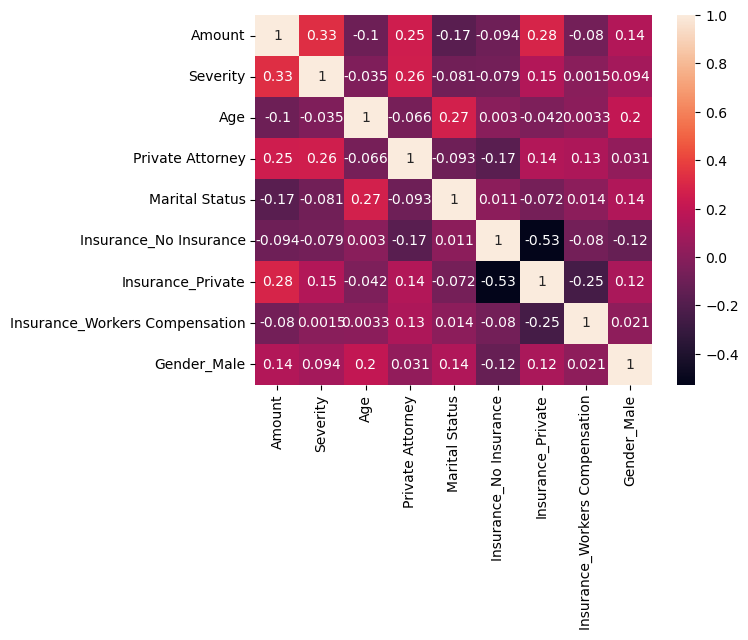

In [5]:
sns.heatmap(df[list(df.columns.values)].corr(), annot=True)

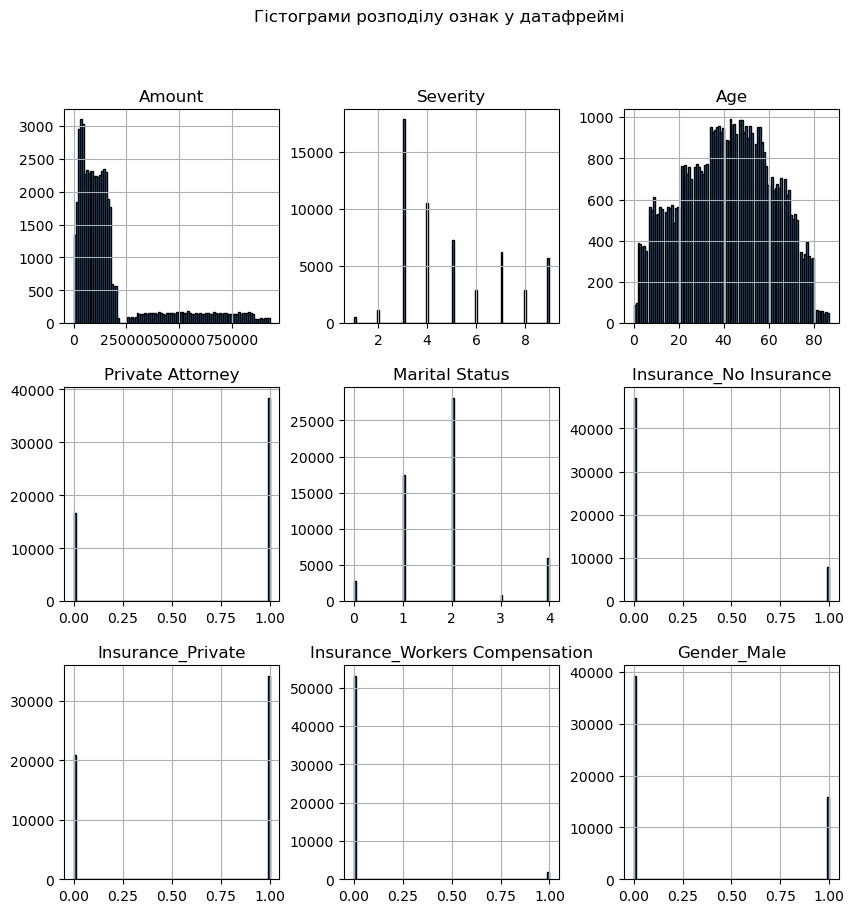

In [6]:
df.hist(bins=100, edgecolor='black', figsize=(10, 10))
plt.suptitle('Гістограми розподілу ознак у датафреймі')
plt.show()

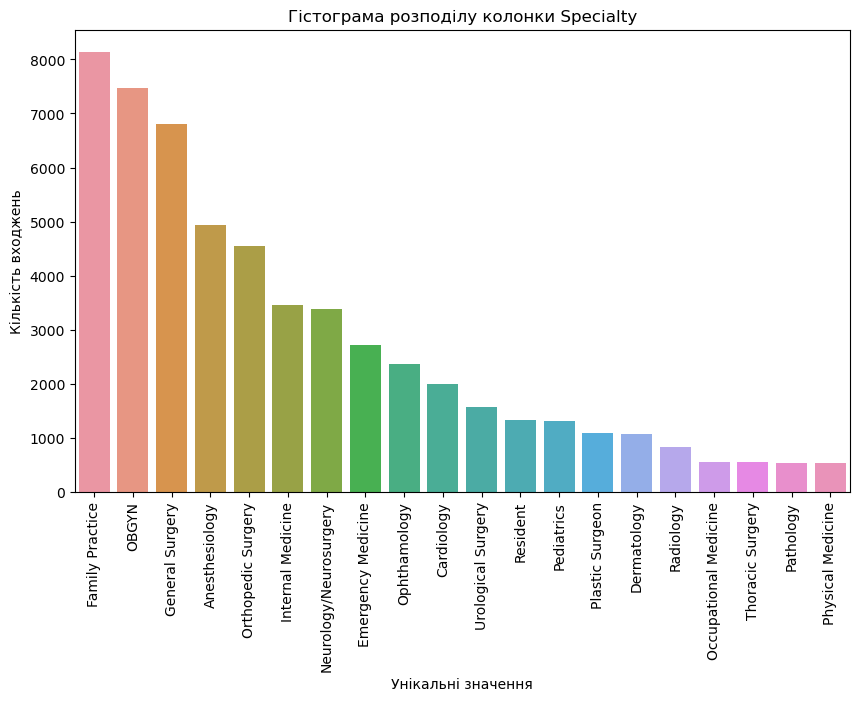

In [7]:
Specialty = pd.DataFrame(Specialty)
plt.figure(figsize=(10, 6))
sns.countplot(x='Specialty', data=Specialty, order=Specialty['Specialty'].value_counts().index)
plt.xlabel('Унікальні значення')
plt.ylabel('Кількість входжень')
plt.title('Гістограма розподілу колонки Specialty')
plt.xticks(rotation=90)
plt.show()

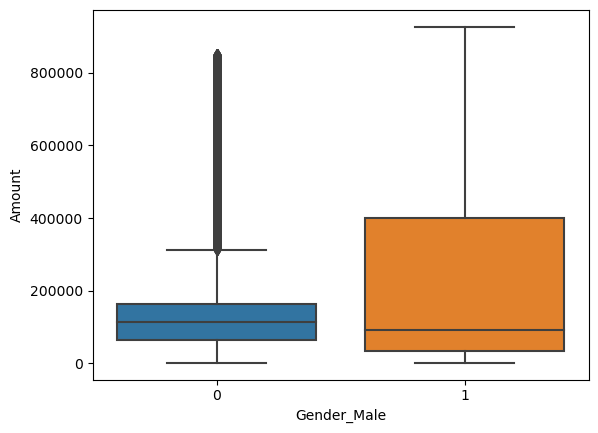

In [8]:
sns.boxplot(x='Gender_Male', y='Amount', data=df)
plt.show()

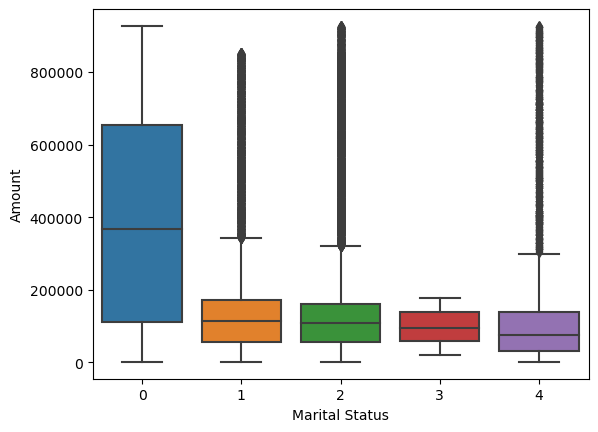

In [9]:
sns.boxplot(x='Marital Status', y='Amount', data=df)
plt.show()

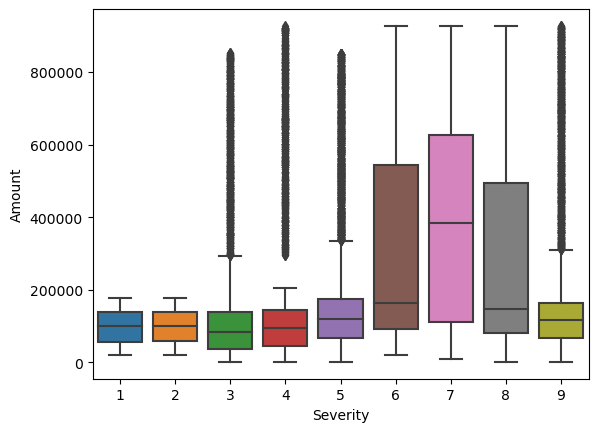

In [10]:
sns.boxplot(x='Severity', y='Amount', data=df)
plt.show()

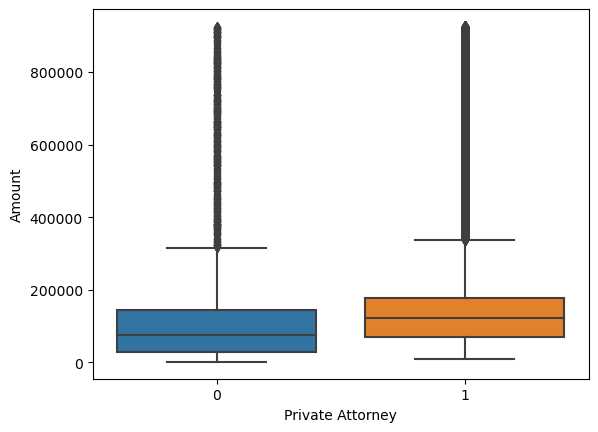

In [11]:
sns.boxplot(x='Private Attorney', y='Amount', data=df)
plt.show()

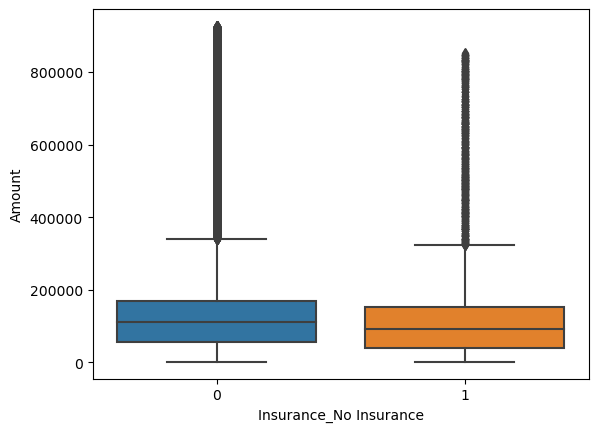

In [12]:
sns.boxplot(x='Insurance_No Insurance', y='Amount', data=df)
plt.show()

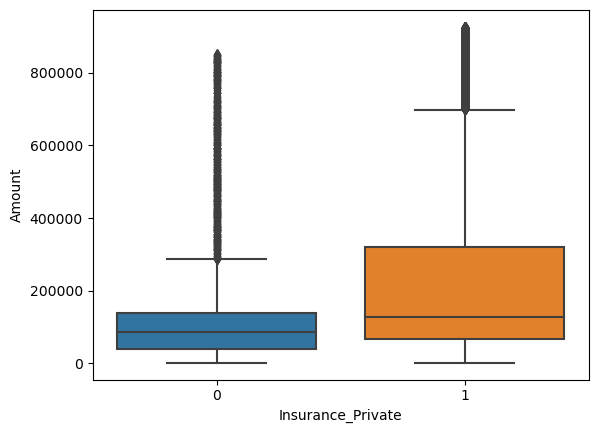

In [13]:
sns.boxplot(x='Insurance_Private', y='Amount', data=df)
plt.show()

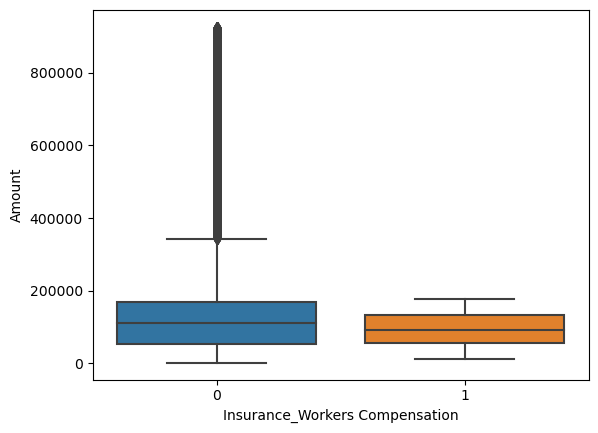

In [14]:
sns.boxplot(x='Insurance_Workers Compensation', y='Amount', data=df)
plt.show()

5) Провести навчання наступних класифікаторів: a) kNN; b) дерево ухвалення рішень; c) SVM; d) Random Forest; e) AdaBoost.

In [15]:
# (a)kNN

x = df.drop(['Gender_Male'], axis=1)
y = df['Gender_Male']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
knn_classifier = KNeighborsClassifier(n_neighbors=100)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.75      0.95      0.84      7822
           1       0.64      0.23      0.33      3210

    accuracy                           0.74     11032
   macro avg       0.69      0.59      0.58     11032
weighted avg       0.72      0.74      0.69     11032

[[7407  415]
 [2486  724]]


In [16]:
# (b) дерево ухвалення рішень

model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      7822
           1       0.76      0.75      0.75      3210

    accuracy                           0.86     11032
   macro avg       0.83      0.82      0.83     11032
weighted avg       0.86      0.86      0.86     11032

[[7059  763]
 [ 812 2398]]


In [17]:
# (c) SVM

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train) 
scaled_X_test = scaler.transform(X_test) 

model = SVC(C=1.0, gamma = 1.0, kernel = 'rbf')
model.fit(scaled_X_train,y_train)
y_pred = model.predict(scaled_X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      7822
           1       0.79      0.75      0.77      3210

    accuracy                           0.87     11032
   macro avg       0.85      0.84      0.84     11032
weighted avg       0.87      0.87      0.87     11032

[[7182  640]
 [ 796 2414]]


In [18]:
# (d) Random Forest

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      7822
           1       0.79      0.76      0.78      3210

    accuracy                           0.87     11032
   macro avg       0.85      0.84      0.84     11032
weighted avg       0.87      0.87      0.87     11032

[[7160  662]
 [ 760 2450]]


In [19]:
# (e) AdaBoost

adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=1)
adaboost_classifier.fit(X_train, y_train)

y_pred = adaboost_classifier.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      7822
           1       0.71      0.55      0.62      3210

    accuracy                           0.80     11032
   macro avg       0.77      0.73      0.74     11032
weighted avg       0.80      0.80      0.80     11032

[[7111  711]
 [1445 1765]]


Як бачимо, накращим з усіх моделей у даному випадку є Random Forest, хоча DecisionTree, SVM та AdaBoost також доволі близькі за результатами переврки точностей. Найгіршим виявився kNN. 